# Disaster Reponse Pipeline Creation 

We are faced with a difficult problem. We have a relatively smalle dataset of 26k messages received during a time of natural disaster. 
Our task is to distinguish signal from noise - in this case the signal is those people who need aid of some kind. The messages originating from those in need may be hard to detect in the tide of messages related to the disaster.
<p>
With luck we can train a classifier or series of classifiers to inform us of signal in noise by applying one or more labels to relevant messages.


### 1. Import libraries and load data from database.
- Import Python libraries
- Load dataset from database with [`read_sql_table`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_sql_table.html)
- Define feature and target variables X and Y

In [1]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

# import libraries
import pandas as pd
import sqlite3
import re

from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
from nltk.corpus import wordnet
from nltk.stem.wordnet import WordNetLemmatizer
from nltk import pos_tag
from nltk.tokenize import word_tokenize

from sqlalchemy import create_engine
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import hamming_loss, make_scorer
from sklearn.multioutput import MultiOutputClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB

from skmultilearn.model_selection import iterative_train_test_split

import matplotlib.pyplot as plt
%matplotlib inline

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\jwilliams1\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\jwilliams1\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\jwilliams1\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\jwilliams1\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
# load data from database
engine = create_engine('sqlite:///DisasterMessages.db')
df = pd.read_sql('SELECT * FROM CleanMessages', engine)

# define variables. X is input, Y is target
X = df['message']
Y = df.drop(['id', 'message', 'original', 'genre'], axis=1) 

In [3]:
# check to make sure we have at least one instance for each label
labels_with_no_instance = Y.columns[~(Y == 1).any(axis=0)]
Y = Y.drop(labels_with_no_instance, axis=1)

In [4]:
labels_with_no_instance

Index(['child_alone'], dtype='object')

In [5]:
# check for labels that are not binary
(Y.isin([0, 1])).all(axis=0)

related                   False
request                    True
offer                      True
aid_related                True
medical_help               True
medical_products           True
search_and_rescue          True
security                   True
military                   True
water                      True
food                       True
shelter                    True
clothing                   True
money                      True
missing_people             True
refugees                   True
death                      True
other_aid                  True
infrastructure_related     True
transport                  True
buildings                  True
electricity                True
tools                      True
hospitals                  True
shops                      True
aid_centers                True
other_infrastructure       True
weather_related            True
floods                     True
storm                      True
fire                       True
earthqua

Uh oh! Looks like all of our labels are binary except for the 'related' column.
Let's check it out.

In [6]:
cnts = Y.related.value_counts()
print(cnts)
print(cnts / cnts.sum())

1    19906
0     6122
2      188
Name: related, dtype: int64
1    0.759307
0    0.233522
2    0.007171
Name: related, dtype: float64


We only have 188 instances of 'related' not binary, which is 0.7% of the instances in the dataset.
Looks like the non binary values of related are 2's. 
Since the number is so small, we'll drop them from the dataset. The reasoning behind this approach is that by dropping these rows, we transform the problem from a multiclass-multilabel problem, known as a multioutput problem, down to a multilabel problem.


In [7]:
index = Y[Y.related == 2].index
Y = Y.drop(index)
X = X.drop(index)

In [8]:
X.shape, Y.shape

((26028,), (26028, 35))

In [9]:
# original data
df.head(5)

,id,message,original,genre,related,request,offer,aid_related,medical_help,medical_products,...,aid_centers,other_infrastructure,weather_related,floods,storm,fire,earthquake,cold,other_weather,direct_report
0,2,Weather update - a cold front from Cuba that c...,Un front froid se retrouve sur Cuba ce matin. ...,direct,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,7,Is the Hurricane over or is it not over,Cyclone nan fini osinon li pa fini,direct,1,0,0,1,0,0,...,0,0,1,0,1,0,0,0,0,0
2,8,Looking for someone but no name,"Patnm, di Maryani relem pou li banm nouvel li ...",direct,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,9,UN reports Leogane 80-90 destroyed. Only Hospi...,UN reports Leogane 80-90 destroyed. Only Hospi...,direct,1,1,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
4,12,"says: west side of Haiti, rest of the country ...",facade ouest d Haiti et le reste du pays aujou...,direct,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [10]:
# check the shape of the original data 
df.shape

(26216, 40)

We've dropped 188 rows and 5 columns.

### 2. Write a tokenization class to process the text data

Lemmatization is a way to reduce words to their root or base form. <br>
The process is more accurate if the lemmatizer knows to which part of speech the word belongs. <br>
Therefore, as part of the lemmatization process, we will tag each word with nltk's pos_tag function. <br>
This POS tag is a Treebank POS tag - in order to utilize it with the WordNet lemmatizer, we have to convert the Treebank POS tag to a WordNet POS tag. <br>
Then, we will pass this POS tag to the lemmatizer along with the word.

In [11]:
# define a function that will allow a treebank POS tag to be converted into a WordNet
# POS Tag so the lemmatizer will understand it
def get_wordnet_pos(treebank_tag):

    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    # default to Noun 
    else:
        return wordnet.NOUN

Removing stop words is another common step in processing text data. Stop words are common words in a language that may potentially confuse a classifier due to their frequency.

We will implement a custom transformer with hyperparameters in order to determine if removing stop words and/or lemmatizing words will have a positive effect on classification efficacy.
This custom transformer follows sklearn's rules for transformers so that it can be used in our processing pipeline.

In [12]:
# implement a custom transformer to determine if removing stops and/or lemmatizing improves model performance

class MessageTokenizer(BaseEstimator, TransformerMixin):
    def __init__(self, remove_stops=True, lemmatize=True):
        self.remove_stops = remove_stops
        self.lemmatize = lemmatize
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        X_transformed = []
        
        # iterate over supplied messages
        for text in X: 
            # sub out any urls 
            text = re.sub(r'^https?:\/\/.*[\r\n]*', '', text, flags=re.MULTILINE)
            
            # remove all non-alphanumeric characters
            text = re.sub(r'[^a-zA-Z0-9]', ' ', text)
              
            # lower and strip whitespace
            text = text.lower().strip()
    
            # tokenize words - nltk.tokenize.word_tokenize
            words = word_tokenize(text)
            
            if self.lemmatize:
                # tag words with Part of Speech - list of (word, POS) tuples 
                # nltk.pos_tag()
                words_with_pos_tag = pos_tag(words)
                
                if self.remove_stops:
                    # remove stop words
                    # stop_words = nlt.corpus.stopwords of 'english' language
                    words_with_pos_tag = [word for word in words_with_pos_tag if word[0] not in stop_words]
                
                # change pos tags to wordnet pos tags for lemmatizer
                words_with_wordnet_tag = []
    
                for word_with_tag in words_with_pos_tag:
                    word, tag = word_with_tag
                    tag = get_wordnet_pos(tag)
                    words_with_wordnet_tag.append((word, tag))

                # lemmatize
                lemm = WordNetLemmatizer()
                # unpack the (word, pos) tuple into the Lemmatizer to give better lemmatization 
                # lemmatization is more effective when it knows the correct part of speech
                words = [lemm.lemmatize(*w) for w in words_with_wordnet_tag]
                
            else:
                if self.remove_stops:
                    words = [word for word in words if word not in stop_words]

            # join cleaned words back into single document
            X_transformed.append(' '.join(words))
        
        return X_transformed    

Show off the custom transformer

In [13]:
text = ["We would not want these words taking up space in our database, or taking up valuable processing time. For this, we can remove them easily, by storing a list of words that you consider to be stop words"]
text.append("Here is another example of words. Isn't it great how words can be manipulated?")

text

['We would not want these words taking up space in our database, or taking up valuable processing time. For this, we can remove them easily, by storing a list of words that you consider to be stop words',
 "Here is another example of words. Isn't it great how words can be manipulated?"]

In [14]:
MessageTokenizer(remove_stops=False, lemmatize=True).transform(text)

['we would not want these word take up space in our database or take up valuable processing time for this we can remove them easily by store a list of word that you consider to be stop word',
 'here be another example of word isn t it great how word can be manipulate']

### 3. Build a first machine learning pipeline
A pipeline allows us to wrap all of our data transformation steps into a neat little package.

In [15]:
pipeline = Pipeline([
    ('msg_tokenizer', MessageTokenizer()),
    # Count Vectorizer with Tokenizer
    ('count_vec', CountVectorizer()),
    # TF-IDF Transformer
    ('tfidf', TfidfTransformer()),
    # classifier - one classifier per label
    ('clf', RandomForestClassifier())
])

### 4. Train pipeline
- Split data into train and test sets
- Train pipeline

Since this is a multilabel classification, I looked into the iterative train-test-split supplied by skmultilearn.
The idea with the iterative train test split is that in theory it can provide better label representation for mutli label problems. Here I will compare whether this train test split results in appropriate label representation for the train set.

In [16]:
# get the proportion of labels in the original data
compare = pd.DataFrame(Y.mean(axis=0), columns=['dataset'])

In [17]:
compare.head()

,dataset
related,0.764792
request,0.171892
offer,0.004534
aid_related,0.417243
medical_help,0.080068


In [18]:
# employ skmultilearn's iterative train test split.
# have to reshape the X values to be multidimensional since that's what this expects

X_train, y_train, X_test, y_test = iterative_train_test_split(X.values.reshape(-1,1), Y.values, test_size = 0.25)

In [19]:
# we want to see how the iterative split did with label proportions
compare['train_set'] = y_train.mean(axis=0)

In [20]:
# normal train test split - how does it compare
X_train2, X_test2, y_train2, y_test2 = train_test_split(X, Y, test_size=0.25)

In [21]:
compare['normal_split'] = y_train2.values.mean(axis=0)

In [22]:
compare

,dataset,train_set,normal_split
related,0.764792,0.764766,0.763793
request,0.171892,0.136929,0.172174
offer,0.004534,0.004559,0.004713
aid_related,0.417243,0.417243,0.416218
medical_help,0.080068,0.087496,0.080068
medical_products,0.050446,0.052764,0.051022
search_and_rescue,0.027816,0.028277,0.027765
security,0.018096,0.019415,0.018493
military,0.033041,0.041596,0.032119
water,0.064239,0.063521,0.064187


In [23]:
diff = pd.DataFrame(compare['dataset'] - compare['normal_split'])
diff.columns = ['dataset - normalsplit']
diff['dataset - iterative split'] = compare['dataset'] - compare['train_set']
diff

,dataset - normalsplit,dataset - iterative split
related,0.000999,0.000026
request,-0.000282,0.034962
offer,-0.000179,-0.000026
aid_related,0.001025,0.000000
medical_help,0.000000,-0.007428
medical_products,-0.000576,-0.002318
search_and_rescue,0.000051,-0.000461
security,-0.000397,-0.001319
military,0.000922,-0.008555
water,0.000051,0.000717


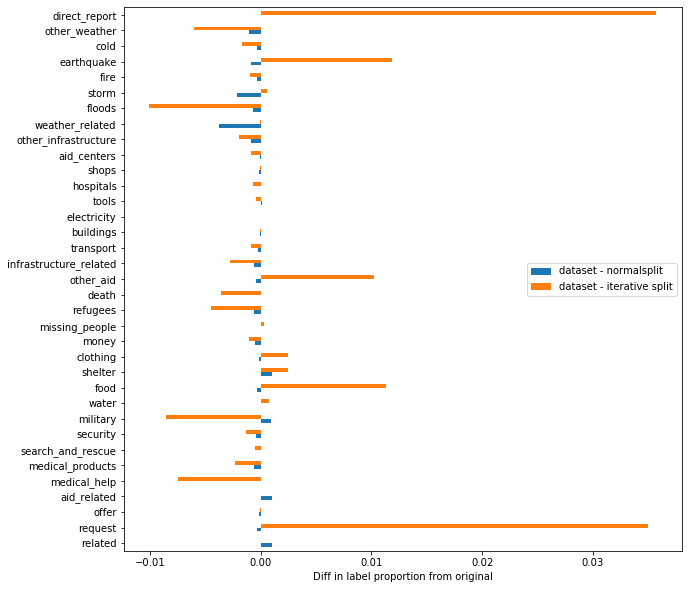

In [24]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1,1, figsize=(10,10))
diff.plot(kind='barh', ax=ax)
plt.xlabel('Diff in label proportion from original')
plt.show()


It seems that the normal train-test-split does a fine, if not better job, of capturing nearly the same proportion of labels as in the original dataset. <br>
Since we will be using a OneVsRest strategy, we are interested in keeping the split proportion close to that of the original dataset.

In [25]:
# normal train test split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.20)

In [26]:
# split the train into train and validation set - we'll hold the test set out for the very end.
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.20)

In [27]:
# fit the pipeline!
pipeline.fit(X_train, y_train)

C:\Users\jwilliams1\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Pipeline(memory=None,
     steps=[('msg_tokenizer', MessageTokenizer(lemmatize=True, remove_stops=True)), ('count_vec', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
...obs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))])

### 5. Test the fitted model on the train data and the validation data.
We'll save the test data for the very end.

In [28]:
y_pred_train = pipeline.predict(X_train)
y_pred_val = pipeline.predict(X_val)

In [29]:
y_prob_train = pipeline.predict_proba(X_train)
y_prob_val = pipeline.predict_proba(X_val)

In [30]:
y_pred_train.shape, y_pred_val.shape, y_test.shape

((16657, 35), (4165, 35), (5206, 35))

In [31]:
# iterate thru all the labels and check the precision, recall, and f1 score on each individual label for the training data 

"""
y_pred_train = pd.DataFrame(y_pred_train, columns=Y.columns)
y_train = pd.DataFrame(y_train, columns=Y.columns)

for col in Y.columns:
    print(col, '\n', classification_report(y_train[col], y_pred_train[col]))
    print(confusion_matrix(y_train[col], y_pred_train[col]))
"""

print("""
Example output:

related 
               precision    recall  f1-score   support

         0.0       0.98      0.98      0.98      3920
         1.0       0.99      0.99      0.99     12737

   micro avg       0.99      0.99      0.99     16657
   macro avg       0.99      0.99      0.99     16657
weighted avg       0.99      0.99      0.99     16657

[[ 3856    64]
 [   68 12669]]
request 
               precision    recall  f1-score   support

         0.0       1.00      0.99      0.99     13952
         1.0       0.93      1.00      0.96      2705

   micro avg       0.99      0.99      0.99     16657
   macro avg       0.97      0.99      0.98     16657
weighted avg       0.99      0.99      0.99     16657

[[13755   197]
 [   11  2694]]

....... lots more
""")


Example output:

related 
               precision    recall  f1-score   support

         0.0       0.98      0.98      0.98      3920
         1.0       0.99      0.99      0.99     12737

   micro avg       0.99      0.99      0.99     16657
   macro avg       0.99      0.99      0.99     16657
weighted avg       0.99      0.99      0.99     16657

[[ 3856    64]
 [   68 12669]]
request 
               precision    recall  f1-score   support

         0.0       1.00      0.99      0.99     13952
         1.0       0.93      1.00      0.96      2705

   micro avg       0.99      0.99      0.99     16657
   macro avg       0.97      0.99      0.98     16657
weighted avg       0.99      0.99      0.99     16657

[[13755   197]
 [   11  2694]]

....... lots more



In [32]:
# looks good on the training data - how does it do on validation data?
"""
y_pred_val = pd.DataFrame(y_pred_val, columns=Y.columns)
y_val = pd.DataFrame(y_val, columns=Y.columns)

for col in Y.columns:
    print(col, '\n', classification_report(y_val[col], y_pred_val[col]))
    print(col, '\n', confusion_matrix(y_val[col], y_pred_val[col]))
    print('\n')
"""
print("""
Example output:

related 
               precision    recall  f1-score   support

         0.0       0.52      0.64      0.58       827
         1.0       0.91      0.86      0.88      3338

   micro avg       0.81      0.81      0.81      4165
   macro avg       0.71      0.75      0.73      4165
weighted avg       0.83      0.81      0.82      4165

related 
 [[ 528  299]
 [ 481 2857]]


request 
               precision    recall  f1-score   support

         0.0       0.98      0.90      0.94      3804
         1.0       0.43      0.81      0.56       361

   micro avg       0.89      0.89      0.89      4165
   macro avg       0.71      0.85      0.75      4165
weighted avg       0.93      0.89      0.90      4165

request 
 [[3415  389]
 [  68  293]]
""")


Example output:

related 
               precision    recall  f1-score   support

         0.0       0.52      0.64      0.58       827
         1.0       0.91      0.86      0.88      3338

   micro avg       0.81      0.81      0.81      4165
   macro avg       0.71      0.75      0.73      4165
weighted avg       0.83      0.81      0.82      4165

related 
 [[ 528  299]
 [ 481 2857]]


request 
               precision    recall  f1-score   support

         0.0       0.98      0.90      0.94      3804
         1.0       0.43      0.81      0.56       361

   micro avg       0.89      0.89      0.89      4165
   macro avg       0.71      0.85      0.75      4165
weighted avg       0.93      0.89      0.90      4165

request 
 [[3415  389]
 [  68  293]]



The performance of the classifier on the training data seems fairly good overall. <br>
However, it's performance on the validation data, which is poor, seems to indicate that it's overfitting the training data. <br>
Another way to gauge the results of a multi-label output is by computing the hamming loss. <br>
Hamming loss is the fraction of labels that are incorrectly predicted, i.e., the fraction of the wrong labels to the total number of labels.<br> 
Hamming loss is a more desirable metric for multi-label problems than accuracy, as accuracy requires every label to match between y_true and y_pred.
<a href="https://scikit-learn.org/stable/modules/generated/sklearn.metrics.hamming_loss.html"> Hamming Loss information </a>

In [33]:
# compute hamming loss as well
print('Hamming loss on train: ', hamming_loss(y_train, y_pred_train))

print('Hamming loss on val: ', hamming_loss(y_val, y_pred_val))

Hamming loss on train:  0.007578109589276066
Hamming loss on val:  0.05996227062253473


Still not too bad overall. The hamming loss tells us that on the validation data, 6% of all labels applied were incorrect. <br>
However, when you consider that many labels are very sparsely represented, we should acknowledge that it is perhaps trivial to achieve this score. 

### Test three different classifiers before tuning hyper params

We will test out
1. Multilayer Perceptron - Directly supports multi-label - <a href="https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html#sklearn.neural_network.MLPClassifier"> link </a>
2. RandomForestClassifier in a OneVsRest framework.
3. A LinearSVC wrapped in OneVsRestClassifier. <br> In essence, train a separate model to predict for each individual label. <a href="https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html"> LinearSVC link </a> and <a href="https://scikit-learn.org/stable/modules/generated/sklearn.multiclass.OneVsRestClassifier.html"> OneVsRest link </a>

In [34]:
# import them

from sklearn.svm import LinearSVC
from sklearn.neural_network import MLPClassifier
from sklearn.multiclass import OneVsRestClassifier

In [35]:
pipeline_mlp = Pipeline([
    ('msg_tokenizer', MessageTokenizer()),
    # Count Vectorizer with Tokenizer
    ('count_vec', CountVectorizer()),
    # TF-IDF Transformer
    ('tfidf', TfidfTransformer()),
    # classifier - one classifier per label
    ('clf', MLPClassifier(early_stopping=True)) # stop early so it doesn't keep training without improvement
])

pipeline_mlp.fit(X_train, y_train)
y_pred_mlp = pipeline_mlp.predict(X_train)
y_pred_val_mlp = pipeline_mlp.predict(X_val)

In [36]:
print(f"Hamming loss: {hamming_loss(y_train, y_pred_mlp)}")
print(f"Hamming loss: {hamming_loss(y_val, y_pred_val_mlp)}")

Hamming loss: 0.03559207197317301
Hamming loss: 0.05580517921454296


It looks like that neural net is overfitting - we can tell because the score is much better on the training set as compared to the validation set. However, the score on the validation set is comparable to our baseline hamming loss, 0.059

Try a RandomForestClassifier, training one model per label.

In [37]:
pipeline_rf = Pipeline([
    ('msg_tokenizer', MessageTokenizer()),
    # Count Vectorizer with Tokenizer
    ('count_vec', CountVectorizer()),
    # TF-IDF Transformer
    ('tfidf', TfidfTransformer()),
    # classifier - one classifier per label
    ('clf', OneVsRestClassifier(RandomForestClassifier()))
])

pipeline_rf.fit(X_train, y_train)
y_pred_rf = pipeline_rf.predict(X_train)
y_pred_val_rf = pipeline_rf.predict(X_val)

C:\Users\jwilliams1\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\jwilliams1\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\jwilliams1\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\jwilliams1\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in versio

C:\Users\jwilliams1\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\jwilliams1\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\jwilliams1\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [38]:
print(f"Hamming loss: {hamming_loss(y_train, y_pred_rf)}")
print(f"Hamming loss: {hamming_loss(y_val, y_pred_val_rf)}")

Hamming loss: 0.007427164898498271
Hamming loss: 0.05741039272851998


The RandomForests are also overfitting - much better score on training data than on validation data. Perhaps we could regularlize the RFs and achieve a better score on the validation data.

LinearSVC

In [39]:
pipeline_svc = Pipeline([
    ('msg_tokenizer', MessageTokenizer()),
    # Count Vectorizer with Tokenizer
    ('count_vec', CountVectorizer()),
    # TF-IDF Transformer
    ('tfidf', TfidfTransformer()),
    # classifier - one classifier per label
    ('clf', OneVsRestClassifier(LinearSVC()))
])

pipeline_svc.fit(X_train, y_train)
y_pred_svc = pipeline_svc.predict(X_train)
y_pred_val_svc = pipeline_svc.predict(X_val)


In [40]:
print(f"Hamming loss: {hamming_loss(y_train, y_pred_svc)}")
print(f"Hamming loss: {hamming_loss(y_val, y_pred_val_svc)}")

Hamming loss: 0.015190524790092539
Hamming loss: 0.05352083690619105


We have achieved our best (by a thin margin) score on the validation data set with LinearSVC. 
Since we used an SVM classifier with a linear kernel, we should be able to achieve similar performance with a Logistic Regression Model - the logistic regression model has the benefit of a built in `predict_proba()` method, which we can use to evaluate performance on individual labels. <br>
Sklearn's linear SVM can also support `predict_proba()` by transforming decision function thresholds into probabilities - however, this can take a while to fit the model.

In [41]:
from sklearn.linear_model import LogisticRegression

pipeline_log = Pipeline([
    ('msg_tokenizer', MessageTokenizer()),
    # Count Vectorizer with Tokenizer
    ('count_vec', CountVectorizer()),
    # TF-IDF Transformer
    ('tfidf', TfidfTransformer()),
    # classifier - one classifier per label
    ('clf', OneVsRestClassifier(LogisticRegression()))
])

pipeline_log.fit(X_train, y_train)
y_pred_log = pipeline_log.predict(X_train)
y_pred_val_log = pipeline_log.predict(X_val)

C:\Users\jwilliams1\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [42]:
print(f"Hamming loss: {hamming_loss(y_train, y_pred_log)}")
print(f"Hamming loss: {hamming_loss(y_val, y_pred_val_log)}")

Hamming loss: 0.04656643710494944
Hamming loss: 0.053246441433716346


As expected, the performance of the Logistic Regression model is comparable to the LinearSVC. This is the model we will select for tuning, due to it having the best performance on our data out of the box, as well as being relatively inexpensive computationally.

### Tuning hyperparameters
In this section, we'll tune our transformation and prediction pipeline using sklearn's RandomizedSearchCV - rather than performing an exhaustive search over every combination in the hyperparameter space, we can instead take `n_iter` samples of the hyperparameter space and search for the best combination there. <p>
    
Each parameter combination will be fit `cv` number of times. So, for n_iter=15 and cv=3, we will fit 15 * 3 * 35 labels = 1,575 models! We expect this will run for awhile. <br>
The RandomizedSearchCV will give us the best cross-validated score and the best param combination.

In [43]:
hamming_scorer = make_scorer(hamming_loss, greater_is_better=False)

In [ ]:
search_params = {
    'msg_tokenizer__remove_stops': [False, True],
    'msg_tokenizer__lemmatize': [False, True],
    'tfidf__norm': [None, 'l1', 'l2'],
    'tfidf__use_idf': [False, True],
    'tfidf__smooth_idf': [False, True],
    'count_vec__ngram_range': [(1,1), (1,2), (1,3), (1,4)],
    'count_vec__max_features': [None, 100, 500, 1000],
    'clf__estimator__dual': [False, True],
    'clf__estimator__C': [1, 10, 50, 100],
    'clf__estimator__class_weight': [None, 'balanced']
}

# set up the randomized search with 15 iterations (15 samples of param combinations)
# each param combination will be fit cv=3 times. Each fit will be scored via hamming loss
# the RandomizedSearchCV will return our best score and best param combination.
cv_log = RandomizedSearchCV(pipeline_log, search_params, n_iter=15, cv=3, scoring=hamming_scorer, verbose=1)
search_log = cv_log.fit(X_train, y_train)

Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
C:\Users\jwilliams1\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\jwilliams1\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\jwilliams1\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\jwilliams1\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", Con

In [ ]:
search_log.best_score_

Example params below.
These are not the final parameters that we will be using. 
I ran the RandomizedSearchCV several times and achieved a better score with slightly different params.

In [ ]:
search_log.best_params_

In [ ]:
# refit with params

pipeline_log = Pipeline([
    ('msg_tokenizer', MessageTokenizer(remove_stops=False, lemmatize=True)),
    # Count Vectorizer with Tokenizer
    ('count_vec', CountVectorizer(ngram_range=(1,4), max_features=1000)),
    # TF-IDF Transformer
    ('tfidf', TfidfTransformer(norm='l2', use_idf=False, smooth_idf=False)),
    # classifier - one classifier per label
    ('clf', OneVsRestClassifier(LogisticRegression(C=10, dual=True, class_weight=None)))
])

pipeline_log.fit(X_train, y_train)
y_pred_log = pipeline_log.predict(X_train)
y_pred_val_log = pipeline_log.predict(X_val)
y_prob_val_log = pipeline_log.predict_proba(X_val)

In [ ]:
print(f"Hamming loss: {hamming_loss(y_train, y_pred_log)}")
print(f"Hamming loss: {hamming_loss(y_val, y_pred_val_log)}")

We have marginally improved our hamming loss on the validation data set. Additionally, hamming loss on training data is close to hamming loss on validation data, indicating that we have successfully regularlized our model. <br>
Note that the `best_score_` is negative - this is because sklearn flips the sign for loss metrics when converting them to a scoring function. <br>
<a href="https://scikit-learn.org/stable/modules/generated/sklearn.metrics.make_scorer.html"> `make_scorer()` info </a> <br>
Now we can examine how the model is performing on individual labels.

In [ ]:
for idx, col in enumerate(Y.columns):
    print(col, '\n', classification_report(y_val.values[:, idx], y_pred_val_log[:, idx]))
    print(confusion_matrix(y_val.values[:, idx], y_pred_val_log[:, idx]), '\n')


We can see that the model is underperforming on labels that have especially low proportions of the positive class.
We can inspect the precision-recall trade off for each individual label to further tune our model.

In [ ]:
# inspect model output for labels where the proportion of positive instances is <= 10%
cols_to_inspect = Y.columns[Y.mean(axis=0) <= 0.10]

### Binary classification metrics
Since a multi-label problem can be regarded as a composition of binary classification tasks, we'll take some time to talk about binary classification metrics.

#### Precision and Recall
This function plots precision versus recall for different probability thresholds.
Precision can be intuitively understood as the ratio of true positives predicted by the model to the total number of positives predicted by the model.
Recall can be intuitively understood as the ratio of true positives predicted by the model to the total number of true positives in the dataset.
    
There is tension between precision and recall - in general, an increase in precision results in a decrease in recall.
The desired balance between the two, depending on your needs and the goal of your model, can be attained by setting the specific decision function threshold at which your model assigns an instance to the positive class.
In short, if you raise the threshold at which your model classifies instances as belonging to the positive class, thereby reducing the number of true negatives that it misclassifies as positives,  you raise the number of true positives that your model misclassifies as negatives.

In [ ]:
# fxns for charting binary classification

def precision_recall_vs_thresholds(y_true, y_scores, label='Class', plot_grid=False):
    """Plot precision and recall vs threshold values of y.
    
    Args:
        y_true (array): binary indication of target variable's true state
        y_scores (array): model's score for each instance
        plot_grid (bool): whether or not to plot gridlines
        
    Returns:
        ax: matplotlib axes object containing the precision recall chart.
    """
    precisions, recalls, thresholds = precision_recall_curve(y_true, y_scores)
    fig, ax = plt.subplots(1, 1, figsize=(12, 8))
    ax.plot(thresholds, precisions[:-1], 'b--', label='Precision')
    ax.plot(thresholds, recalls[:-1], 'g-', label='Recall')
    ax.set_xlabel('Thresholds')
    ax.set_ylim([0, 1])
    ax.legend(loc='upper right')
    
    if plot_grid:
        threshs = np.round(np.arange(0.0, 1.05, 0.05), 2)
        for thr in threshs:
            ax.axvline(thr, alpha=0.15)
            ax.axhline(thr, alpha=0.15)
        ax.set_xticks(threshs)
        ax.set_xticklabels(threshs, rotation=90)
        ax.set_yticks(threshs)
        ax.set_yticklabels(threshs)
    
    ax.set_ylabel('probability')
    ax.set_title(f'Precision vs Recall Curves for p({label}=1) Thresholds')
    
    return ax

In [ ]:
y_prob_val_log.shape

In [ ]:
for idx, col in enumerate(Y.columns):
    if col in cols_to_inspect:
        y_scores = y_prob_val_log[:, idx]
        y_true = y_val.values[:, idx]
        precision_recall_vs_thresholds(y_true, y_scores, label=col, plot_grid=True)
        plt.show()

After reviewing the precision-recall charts, we can set custom probability thresholds per label. The reasoning here is that, since our positive class instances are very sparsely represented and signify people in some distress, we are more interested in capturing as many true positives as we can (increasing our recall). <br> This will come at the expense of decreasing our precision, meaning that we will falsely predict more positive instances.

In [ ]:
custom_thresh = {
    'offer': 0.025,
    'medical_help': 0.20,
    'medical_products': 0.20,
    'search_and_rescue': 0.15,
    'security': 0.05,
    'military': 0.125,
    'water': 0.20,
    'shelter': 0.20,
    'clothing': 0.10,
    'money': 0.10,
    'missing_people': 0.075,
    'refugees': 0.15,
    'death': 0.20,
    'infrastructure_related': 0.15,
    'transport': 0.15,
    'buildings': 0.20,
    'electricity': 0.15,
    'tools': 0.10,
    'hospitals': 0.15,
    'shops': 0.10,
    'aid_centers': 0.05,
    'other_infrastructure': 0.10,
    'floods': 0.15,
    'storm': 0.15,
    'fire': 0.05,
    'earthquake': 0.15,
    'cold': 0.15,
    'other_weather': 0.15
}

In [ ]:
def predict_with_thresh(estimator, X, labels_array, thresholds):
    """Return binary classification based on custom thresholds.
    
    Args:
        estimator: an object capable of predict() and predict_proba() methods
        X: data to predict on 
        labels_array: array/list of label names
        thresholds (dict): dictionary of label:threshold values
        
    Returns:
        y_pred (arr): binary array of prediction based on custom threshold.    
    """
    y_prob = estimator.predict_proba(X)
    # placeholder for labels that do not have custom thresholds
    y_pred = estimator.predict(X)    
    for idx, label in enumerate(labels_array):
        if label in thresholds.keys():
            # replace the default prediction with the custom prediction
            y_pred[:, idx] = y_prob[:, idx] >= thresholds[label] * 1 # convert bool to int
    
    return y_pred

In [ ]:
y_pred_val_custom = predict_with_thresh(pipeline_log, X_val, Y.columns, custom_thresh)

In [ ]:
for idx, col in enumerate(Y.columns):
    print(col, '\n', 'custom thresholds: ', classification_report(y_val.values[:, idx], y_pred_val_custom[:, idx]))
    print(confusion_matrix(y_val.values[:, idx], y_pred_val_custom[:, idx]), '\n')
    print('\n', 'normal thresholds: ', classification_report(y_val.values[:, idx], y_pred_val_log[:, idx]))
    print(confusion_matrix(y_val.values[:, idx], y_pred_val_log[:, idx]), '\n')

Reviewing the output of the above, you can see that we have increased the number of true positive classifications for labels with sparse representation. This has come at the cost of increasing our number of false positives. However, when you consider the context of the problem, it is perhaps better to marginally increase the number of false positives classified if it means capturing more true instances of people in need. <br>
In all likelihood, these classifications would be reviewed by somebody attempting to orchestrate aid efforts - better to slightly increase the noise if it means identifying more of those in need.

Finally, let's test out our model on the last holdout data set.

In [ ]:
# with custom thresholds
y_pred_test_custom = predict_with_thresh(pipeline_log, X_test, Y.columns, custom_thresh)

In [ ]:
print(f"Hamming loss on test: {hamming_loss(y_test, y_pred_test_custom)}")

In [ ]:
for idx, col in enumerate(Y.columns):
    print(col, '\n', classification_report(y_test.values[:, idx], y_pred_test_custom[:, idx]))
    print(confusion_matrix(y_test.values[:, idx], y_pred_test_custom[:, idx]), '\n')

In [ ]:
y_pred_test = pipeline_log.predict(X_test)

In [ ]:
print(f"Hamming loss on test: {hamming_loss(y_test, y_pred_test)}")

This model is not perfect, but is both fast and fairly good at predicting the required labels, only missing 5% of labels on the holdout set.